<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D1_updates/tutorials/W3D1_BayesianDecisions/W3D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 2
# Bayesian inference and decisions with continuous hidden state

__Content creators:__ Eric DeWitt, Xaq Pitkow, Saeed Salehi, Ella Batty

__Content reviewers:__ 

# Tutorial Objectives

This notebook introduces you to Gaussians and Bayes' rule for continuous distributions, allowing us to model simple put powerful combinations of prior information and new measurements. In this notebook you will work through the same ideas we explored in the binary state tutorial, but you will be introduced to a new problem: finding and guiding Astrocat! You will see this problem again in more complex ways in the following days.

In this notebook, you will:

1. Learn about the Gaussian distribution and its nice properies
2. Explore how we can extend the ideas from the binary hidden tutorial to continuous distributions
3. Explore how different priors can produce more complex posteriors.
4. Explore Loss functions often used in inference and complex utility functions.

---
##Setup  
Please execute the cells below to initialize the notebook environment.

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import gamma as gamma_distribution
from matplotlib.transforms import Affine2D

In [ ]:
#@title Figure Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import FloatSlider
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# @title Plotting functions

def plot_gaussian(μ, σ):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y = gaussian(x, μ, σ)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, c='blue')
    plt.fill_between(x, y, color='b', alpha=0.2)
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.yticks([])
    plt.show()


def plot_losses(μ, σ):
    x = np.linspace(-2, 2, 400, endpoint=True)
    y = gaussian(x, μ, σ)
    error = x - μ

    mse_loss = (error)**2
    abs_loss = np.abs(error)
    zero_one_loss = (np.abs(error) >= 0.02).astype(np.float)

    fig, (ax_gaus, ax_error) = plt.subplots(2, 1, figsize=(6, 8))
    ax_gaus.plot(x, y, color='blue', label='true distribution')
    ax_gaus.fill_between(x, y, color='blue', alpha=0.2)
    ax_gaus.set_ylabel('$\\mathcal{N}(x, \\mu, \\sigma^2)$')
    ax_gaus.set_xlabel('x')
    ax_gaus.set_yticks([])
    ax_gaus.legend(loc='upper right')

    ax_error.plot(x, mse_loss, color='c', label='Mean Squared Error', linewidth=3)
    ax_error.plot(x, abs_loss, color='m', label='Absolute Error', linewidth=3)
    ax_error.plot(x, zero_one_loss, color='y', label='Zero-One Loss', linewidth=3)
    ax_error.legend(loc='upper right')
    ax_error.set_xlabel('$\\hat{\\mu}$')
    ax_error.set_ylabel('Error')
    plt.show()


def plot_mvn2d(mu1, mu2, sigma1, sigma2, corr):
    x, y = np.mgrid[-2:2:.02, -2:2:.02]
    cov12 = corr * sigma1 * sigma2
    z = mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12)

    plt.figure(figsize=(6, 6))
    plt.contourf(x, y, z, cmap='Reds')
    plt.axis("off")
    plt.show()


def plot_marginal(sigma1, sigma2, c_x, c_y, corr):
    mu1, mu2 = 0.0, 0.0
    cov12 = corr * sigma1 * sigma2
    xx, yy = np.mgrid[-2:2:.02, -2:2:.02]
    x, y = xx[:, 0], yy[0]
    p_x = gaussian(x, mu1, sigma1)
    p_y = gaussian(y, mu2, sigma2)
    zz = mvn2d(xx, yy, mu1, mu2, sigma1, sigma2, cov12)

    mu_x_y = mu1+cov12*(c_y-mu2)/sigma2**2
    mu_y_x = mu2+cov12*(c_x-mu1)/sigma1**2
    sigma_x_y = np.sqrt(sigma2**2 - cov12**2/sigma1**2)
    sigma_y_x = np.sqrt(sigma1**2-cov12**2/sigma2**2)
    p_x_y = gaussian(x, mu_x_y, sigma_x_y)
    p_y_x = gaussian(x, mu_y_x, sigma_y_x)

    p_c_y = gaussian(mu_x_y-sigma_x_y, mu_x_y, sigma_x_y)
    p_c_x = gaussian(mu_y_x-sigma_y_x, mu_y_x, sigma_y_x)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.01

    rect_z = [left, bottom, width, height]
    rect_x = [left, bottom + height + spacing, width, 0.2]
    rect_y = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax_z = fig.add_axes(rect_z)
    ax_x = fig.add_axes(rect_x, sharex=ax_z)
    ax_y = fig.add_axes(rect_y, sharey=ax_z)

    ax_z.set_axis_off()
    ax_x.set_axis_off()
    ax_y.set_axis_off()
    ax_x.set_xlim(np.min(x), np.max(x))
    ax_y.set_ylim(np.min(y), np.max(y))

    ax_z.contourf(xx, yy, zz, cmap='Greys')
    ax_z.hlines(c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', zorder=9, linewidth=3)
    ax_z.vlines(c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', zorder=9, linewidth=3)

    ax_x.plot(x, p_x, label='$p(x)$', c = 'b', linewidth=3)
    ax_x.plot(x, p_x_y, label='$p(x|y = C_y)$', c = 'c', linestyle='dashed', linewidth=3)
    ax_x.hlines(p_c_y, mu_x_y-sigma_x_y, mu_x_y+sigma_x_y, color='c', linestyle='dashed', linewidth=3)

    ax_y.plot(p_y, y, label='$p(y)$', c = 'r', linewidth=3)
    ax_y.plot(p_y_x, y, label='$p(y|x = C_x)$', c = 'm', linestyle='dashed', linewidth=3)
    ax_y.vlines(p_c_x, mu_y_x-sigma_y_x, mu_y_x+sigma_y_x, color='m', linestyle='dashed', linewidth=3)

    ax_x.legend(loc="upper left", frameon=False)
    ax_y.legend(loc="lower right", frameon=False)

    plt.show()


def plot_bayes(mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()

def plot_information(mu1, sigma1, mu2, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    mu3, sigma3 = product_guassian(mu1, mu2, sigma1, sigma2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()

def plot_information_global(mu3, sigma3, mu1, mu2):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    sigma1, sigma2 = reverse_product(mu3, sigma3, mu1, mu2)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    posterior = gaussian(x, mu3, sigma3)

    plt.figure(figsize=(8, 6))
    plt.plot(x, prior, c='b', label='Satellite')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='Space Mouse')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='Center')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.ylabel('$\mathcal{N}(x, \mu, \sigma^2)$')
    plt.xlabel('x')
    plt.show()


def plot_loss_utility_gaussian(loss_f, mu, sigma, mu_true):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)

    plot_loss_utility(x, posterior, loss_f, mu_true)


def plot_loss_utility_mixture(loss_f, mu1, mu2, sigma1, sigma2, factor, mu_true):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    posterior = y_1 * factor + y_2 * (1.0 - factor)

    plot_loss_utility(x, posterior, loss_f, mu_true)


def plot_loss_utility(x, posterior, loss_f, mu_true):
    mean, median, mode = calc_mean_mode_median(x, posterior)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = calc_expected_loss(loss_f, posterior, x)
    min_expected_loss = x[np.argmin(utility)]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    plt.xlabel('x')
    plt.ylabel('$\pi \cdot p(x) + (1-\pi) \cdot p(y)$')
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    
    plt.subplot(2, 2, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')
    # plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title("Expected Loss")
    plt.plot(x, utility, c='y', label='$\mathbb{E}[L]$')
    plt.axvline(min_expected_loss, ls='dashed', color='red', label='$Min~ \mathbb{E}[Loss]$')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="lower right")
    plt.xlabel('x')
    plt.ylabel('$\mathbb{E}[L]$')

    plt.show()


def plot_loss_utility_bayes(mu1, mu2, sigma1, sigma2, mu_true, loss_f):
    x = np.linspace(-4, 4, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    utility = - calc_expected_loss(loss_f, posterior, x)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)

    plt.title("Posterior distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title(loss_f)
    plt.plot(x, loss, c='c')
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')

    plt.subplot(1, 3, 3)
    plt.title("Expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_simple_utility_gaussian(mu, sigma, mu_g, mu_c, sigma_g, sigma_c):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    posterior = gaussian(x, mu, sigma)
    gain = gaussian(x, mu_g, sigma_g)
    loss = gaussian(x, mu_c, sigma_c)
    utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Probability")
    plt.plot(x, posterior, c='b', label='posterior')
    plt.fill_between(x, posterior, color='b', alpha=0.2)
    plt.yticks([])
    # plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(1, 3, 2)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    # plt.fill_between(x, gain, color='m', alpha=0.2)
    plt.plot(x, -loss, c='c', label='loss')
    # plt.fill_between(x, -loss, color='c', alpha=0.2)
    plt.legend(loc="upper left")

    plt.subplot(1, 3, 3)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.legend(loc="upper left")

    plt.show()


def plot_utility_gaussian(mu1, mu2, sigma1, sigma2, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)

    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_mixture(mu_m1, mu_m2, sigma_m1, sigma_m2, factor,
                         mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)

    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_uniform(mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)

    posterior = likelihood
    # posterior = np.multiply(prior, likelihood)
    # posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_utility_gamma(alpha, beta, offset, mu, sigma, mu_g, mu_c, sigma_g, sigma_c, plot_utility_row=True):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    if plot_utility_row:
        gain = gaussian(x, mu_g, sigma_g)
        loss = gaussian(x, mu_c, sigma_c)
        utility = np.multiply(posterior, gain) - np.multiply(posterior, loss)
        plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility)
    else:
        plot_bayes_row(x, prior, likelihood, posterior)

    return None


def plot_bayes_row(x, prior, likelihood, posterior):

    mean, median, mode = calc_mean_mode_median(x, posterior)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Prior and likelihood distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    # plt.plot(x, posterior, c='k', label='posterior')
    # plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(1, 2, 2)
    plt.title("Posterior distribution")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.show()


def plot_bayes_utility_rows(x, prior, likelihood, posterior, gain, loss, utility):

    mean, median, mode = calc_mean_mode_median(x, posterior)
    max_utility = x[np.argmax(utility)]
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title("Prior and likelihood distribution")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    # plt.plot(x, posterior, c='k', label='posterior')
    # plt.fill_between(x, posterior, color='k', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')

    plt.subplot(2, 2, 2)
    plt.title("Posterior distribution")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title("utility function")
    plt.plot(x, gain, c='m', label='gain')
    # plt.fill_between(x, gain, color='m', alpha=0.2)
    plt.plot(x, -loss, c='c', label='loss')
    # plt.fill_between(x, -loss, color='c', alpha=0.2)
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(2, 2, 4)
    plt.title("expected utility")
    plt.plot(x, utility, c='y', label='utility')
    # plt.fill_between(x, utility, color='y', alpha=0.2)
    plt.axvline(max_utility, ls='dashed', color='red', label='Max utility')
    plt.legend(loc="upper left")
    plt.xlabel('x')
    plt.ylabel('utility')
    plt.legend(loc="lower right")

    plt.show()


def gaussian_mixture(mu1, mu2, sigma1, sigma2, factor):
    assert 0.0 < factor < 1.0
    x = np.linspace(-7.0, 7.0, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    mixture = y_1 * factor + y_2 * (1.0 - factor)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y_1, c='deepskyblue', label='p(x)', linewidth=3.0)
    plt.fill_between(x, y_1, color='deepskyblue', alpha=0.2)
    plt.plot(x, y_2, c='aquamarine', label='p(y)', linewidth=3.0)
    plt.fill_between(x, y_2, color='aquamarine', alpha=0.2)
    plt.plot(x, mixture, c='b', label='$\pi \cdot p(x) + (1-\pi) \cdot p(y)$',  linewidth=3.0)
    plt.fill_between(x, mixture, color='b', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')
    plt.show()


def plot_bayes_loss_utility_gaussian(loss_f, mu_true, mu1, mu2, sigma1, sigma2):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = gaussian(x, mu1, sigma1)
    likelihood = gaussian(x, mu2, sigma2)
    mu_post, sigma_post = product_guassian(mu1, mu2, sigma1, sigma2)
    posterior = gaussian(x, mu_post, sigma_post)

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_uniform(loss_f, mu_true, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)

    prior = np.ones_like(x) / (x.max() - x.min())
    likelihood = gaussian(x, mu, sigma)
    posterior = likelihood

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_gamma(loss_f, mu_true, alpha, beta, offset, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    prior = gamma_pdf(x-offset, alpha, beta)
    likelihood = gaussian(x, mu, sigma)
    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility_mixture(loss_f, mu_true, mu_m1, mu_m2, sigma_m1, sigma_m2, factor, mu, sigma):
    x = np.linspace(-7, 7, 1000, endpoint=True)
    y_1 = gaussian(x, mu_m1, sigma_m1)
    y_2 = gaussian(x, mu_m2, sigma_m2)
    prior = y_1 * factor + y_2 * (1.0 - factor)
    likelihood = gaussian(x, mu, sigma)

    posterior = np.multiply(prior, likelihood)
    posterior = posterior / (posterior.sum() * (x[1] - x[0]))

    loss = calc_loss_func(loss_f, mu_true, x)

    plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f)

    return None


def plot_bayes_loss_utility(x, prior, likelihood, posterior, loss, loss_f):

    mean, median, mode = calc_mean_mode_median(x, posterior)
    expected_loss = calc_expected_loss(loss_f, posterior, x)
    min_expected_loss = x[np.argmin(expected_loss)]

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title("Prior and Likelihood")
    plt.plot(x, prior, c='b', label='prior')
    plt.fill_between(x, prior, color='b', alpha=0.2)
    plt.plot(x, likelihood, c='r', label='likelihood')
    plt.fill_between(x, likelihood, color='r', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.xlabel('x')

    plt.subplot(2, 2, 2)
    plt.title("Posterior")
    plt.plot(x, posterior, c='k', label='posterior')
    plt.fill_between(x, posterior, color='k', alpha=0.1)
    plt.axvline(mean, ls='dashed', color='red', label='Mean')
    plt.axvline(median, ls='dashdot', color='blue', label='Median')
    plt.axvline(mode, ls='dotted', color='green', label='Mode')
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.xlabel('x')

    plt.subplot(2, 2, 3)
    plt.title(loss_f)
    plt.plot(x, loss, c='c', label=loss_f)
    # plt.fill_between(x, loss, color='c', alpha=0.2)
    plt.ylabel('loss')
    plt.xlabel('x')

    plt.subplot(2, 2, 4)
    plt.title("expected loss")
    plt.plot(x, expected_loss, c='y', label='$\mathbb{E}[L]$')
    # plt.fill_between(x, expected_loss, color='y', alpha=0.2)
    plt.axvline(min_expected_loss, ls='dashed', color='red', label='$Min~ \mathbb{E}[Loss]$')
    plt.legend(loc="lower right")
    plt.xlabel('x')
    plt.ylabel('$\mathbb{E}[L]$')

    plt.show()


def loss_plot_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_loss_utility_gaussian,
            loss_f = widgets.Dropdown(
                options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                value="Mean Squared Error", description="Loss: "),
            mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_estimate", continuous_update=False),
            sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_estimate", continuous_update=False),
            mu_true = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=False))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_loss_utility_mixture,
            mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_est_1", continuous_update=False),
            mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_est_2", continuous_update=False),
            sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_1", continuous_update=False),
            sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_est_2", continuous_update=False),
            factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
            mu_true = FloatSlider(min=-3.0, max=3.0, step=0.01, value=0.0, description="µ_true", continuous_update=False),
            loss_f = widgets.Dropdown(
                options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                value="Mean Squared Error", description="Loss: "))


def plot_prior_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = fixed(1.0),
                  mu_c = fixed(-1.0),
                  sigma_g = fixed(0.5),
                  sigma_c = fixed(value=0.5),
                  plot_utility_row=fixed(False))
    elif what_to_plot == "Uniform":
        widget = interact(plot_utility_uniform,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = fixed(1.0),
                  mu_c = fixed(-1.0),
                  sigma_g = fixed(0.5),
                  sigma_c = fixed(value=0.5),
                  plot_utility_row=fixed(False))
    elif what_to_plot == "Gamma":
        widget = interact(plot_utility_gamma,
                  alpha = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=False),
                  beta = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=False),
                  offset = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = fixed(1.0),
                  mu_c = fixed(-1.0),
                  sigma_g = fixed(0.5),
                  sigma_c = fixed(value=0.5),
                  plot_utility_row=fixed(False))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_utility_mixture,
                  mu_m1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_1", continuous_update=False),
                  mu_m2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_1", continuous_update=False),
                  sigma_m1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_1", continuous_update=False),
                  sigma_m2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_2", continuous_update=False),
                  factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = fixed(1.0),
                  mu_c = fixed(-1.0),
                  sigma_g = fixed(0.5),
                  sigma_c = fixed(value=0.5),
                  plot_utility_row=fixed(False))
        
        
def plot_bayes_loss_utility_switcher(what_to_plot):
    if what_to_plot == "Gaussian":
        widget = interact(plot_bayes_loss_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Uniform":
        widget = interact(plot_bayes_loss_utility_uniform,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Gamma":
        widget = interact(plot_bayes_loss_utility_gamma,
                  alpha = FloatSlider(min=1.0, max=10.0, step=0.1, value=2.0, description="α_prior", continuous_update=False),
                  beta = FloatSlider(min=0.5, max=2.0, step=0.01, value=1.0, description="β_prior", continuous_update=False),
                  offset = FloatSlider(min=-6.0, max=2.0, step=0.1, value=0.0, description="offset", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))
    elif what_to_plot == "Mixture of Gaussians":
        widget = interact(plot_bayes_loss_utility_mixture,
                  mu_m1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_mix_1", continuous_update=False),
                  mu_m2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_mix_1", continuous_update=False),
                  sigma_m1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_1", continuous_update=False),
                  sigma_m2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_mix_2", continuous_update=False),
                  factor = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description="π", continuous_update=False),
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_true = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_true", continuous_update=False),
                  loss_f = widgets.Dropdown(
                      options=["Mean Squared Error", "Absolute Error", "Zero-One Loss"], 
                      value="Mean Squared Error", description="Loss: "))


In [ ]:
# @title Helper functions

def gaussian(x, μ, σ):
    return np.exp(-((x - μ) / σ)**2 / 2) / np.sqrt(2 * np.pi * σ**2)


def gamma_pdf(x, α, β):
    return gamma_distribution.pdf(x, a=α, scale=1/β)


def mvn2d(x, y, mu1, mu2, sigma1, sigma2, cov12):
    mvn = multivariate_normal([mu1, mu2], [[sigma1**2, cov12], [cov12, sigma2**2]])
    return mvn.pdf(np.dstack((x, y)))


def product_guassian(mu1, mu2, sigma1, sigma2):
    J_1, J_2 = 1/sigma1**2, 1/sigma2**2
    J_3 = J_1 + J_2
    mu_prod = (J_1*mu1/J_3) + (J_2*mu2/J_3)
    sigma_prod = np.sqrt(1/J_3)
    return mu_prod, sigma_prod


def reverse_product(mu3, sigma3, mu1, mu2):
    J_3 = 1/sigma3**2
    J_1 = J_3 * (mu3 - mu2) / (mu1 - mu2)
    J_2 = J_3 * (mu3 - mu1) / (mu2 - mu1)
    sigma1, sigma2 = 1/np.sqrt(J_1), 1/np.sqrt(J_2)
    return sigma1, sigma2


def calc_mean_mode_median(x, y):
    """

    """
    pdf = y * (x[1] - x[0])
    # Calc mode of an arbitrary function
    mode = x[np.argmax(pdf)]

    # Calc mean of an arbitrary function
    mean = np.multiply(x, pdf).sum()

    # Calc median of an arbitrary function
    cdf = np.cumsum(pdf)
    idx = np.argmin(np.abs(cdf - 0.5))
    median = x[idx]

    return mean, median, mode



def calc_expected_loss(loss_f, posterior, x):
    dx = x[1] - x[0]
    expected_loss = np.zeros_like(x)
    for i in np.arange(x.shape[0]):
        loss = calc_loss_func(loss_f, x[i], x) # or mse or zero_one_loss
        expected_loss[i] = np.sum(loss * posterior) * dx
    return expected_loss

def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians

    Args:
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

def gaussian_mixture(mu1, mu2, sigma1, sigma2, factor):
    assert 0.0 < factor < 1.0
    x = np.linspace(-7.0, 7.0, 1000, endpoint=True)
    y_1 = gaussian(x, mu1, sigma1)
    y_2 = gaussian(x, mu2, sigma2)
    mixture = y_1 * factor + y_2 * (1.0 - factor)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y_1, c='deepskyblue', label='p(x)', linewidth=3.0)
    plt.fill_between(x, y_1, color='deepskyblue', alpha=0.2)
    plt.plot(x, y_2, c='aquamarine', label='p(y)', linewidth=3.0)
    plt.fill_between(x, y_2, color='aquamarine', alpha=0.2)
    plt.plot(x, mixture, c='b', label='$\pi \cdot p(x) + (1-\pi) \cdot p(y)$',  linewidth=3.0)
    plt.fill_between(x, mixture, color='b', alpha=0.2)
    plt.yticks([])
    plt.legend(loc="upper left")
    # plt.ylabel('$f(x)$')
    plt.xlabel('x')
    plt.show()



---
# Section 1: Astrocat!

Video available at https://youtube.com/watch?v=D7Z-aTX92Pk


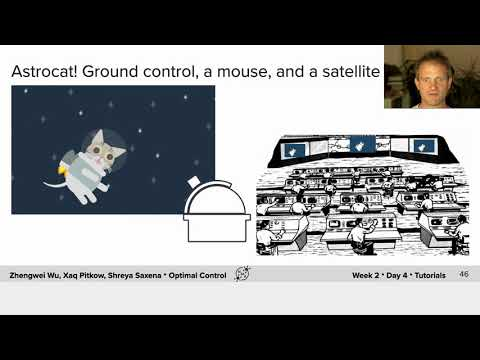

In [ ]:
# @title Video 1: Astrocat!
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='D7Z-aTX92Pk', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Remember, in this example, you can think of yourself as a scientist trying to decide where we belive Astrocat is, how to select a point estimate (single guess of location) based on possible errors, and how to account for the uncertainty we have about the location of the satellite and the space mouse. In fact, this is the kind of problem real scientists working to control remote satellites face! However, we can also think of this as what your brain has does when it wants to determine a target to make a movement or hit a tennis ball! A number of classic experiments use this kind of framing to study how *optimal* human decisions or movements are! Some examples are in the further reading document.

---
# Section 2: Probability distribution of Astrocat location



We are going to think first about how Ground Control should estimate his position. We won't consider measurements yet, just how to represent the uncertainty we might have in general. We are now dealing with a continuous distribution - Astrocat's location can be any real number. In the last tutorial, we were dealing with a discrete distribution - the fish were either on one side or the other. 

So how do we represent the probability of each possible point (an infinite number) where the Astrocat could be? 
The Bayesian approach can be used on any probability distribution. While many variables in the world require representation using complex or unknown (e.g. empirical) distributions, we will be using the Gaussian distributions or extensions of it.

## Section 2.1: The Gaussian distribution


One distribution we will use throughout this tutorial is the **Gaussian distribution**, which is also sometimes called the normal distribution. 

This is a special, and commonly used, distribution for a couple reasons. It is actually the focus of one of the most important theorems in statistics: the Central Limit Theorem. This theorem tells us that if you sum a large number of samples of a variable, that sum is normally distributed *no matter what* the original distribution over a variable was. This is a bit too in-depth for us to get into now but check out links in the Bonus for more information. Additionally, Gaussians have some really nice mathematical properties that permit simple closed-form solutions to several important problems. As we will see later in this tutorial, we can extend Gaussians to be even more flexible and well approximate other distributions using mixtures of Gaussians. In short, the Gaussian is probably the most important continous distribution to understand and use.


Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center. Its "scale" or spread is controlled by its **standard deviation** $\sigma$ or its square, the **variance** $\sigma^2$. These can be a bit easy to mix up: make sure you are careful about whether you are referring to/using standard deviation or variance.

The equation for a Gaussian distribution on a variable $x$ is:

$$
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$

In our example, $x$ is the location of the Astrocat in one direction. $\mathcal{N}(\mu,\sigma^2)$ is a standard notation to refer to a **N**ormal (Gaussian) distribution. For example, $\mathcal{N}(0, 1)$ denotes a Gaussian distribution with mean 0 and variance 1. The exact form of this equation is not particularly intuitive, but we will see how mean and standard deviation values affect the probability distribution.


We won't implement a Gaussian distribution in code here but please refer to the pre-reqs refresher W0D5 T1 to do this if you need further clarification.


In [ ]:
# @markdown Execute this cell to enable the function `gaussian`
def gaussian(x, μ, σ):
    return np.exp(-((x - μ) / σ)**2 / 2) / np.sqrt(2 * np.pi * σ**2)


### Interactive Demo 2.1: Exploring Gaussian parameters:

Let's explore how the parameters of a Gaussian affect the distribution. Play with the demo below by changing the mean $\mu$ and standard deviation $\sigma$.

Discuss the following:

1. What does increasing $\mu$ do? What does increasing $\sigma$ do?
2. If you wanted to know the probability of an event happing at $0$, can you find two different $\mu$ and $\sigma$ values that produce the same probabilty of an event at $0$?
3. How many Gaussian's could produce the same probabilty at $0$?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_gaussian,
                     μ = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.0, continuous_update=False),
                     σ = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, continuous_update=False))


In [ ]:
# to_remove explanation

#. 1. Increasing u moves the distribution to the right along the x-axis. The center
#.    of the distribution equals u - which makes sense as this is the mean! Increasing
#.    the standard deviation makes the distribution wider.

#.  2. Yes, you can! For example, keep the standard deviation the same and move the mean 
#.     from -2 to 2. At both of these, the probability at 0 is the same because the distribution
#.     is symmetrical.

#.  3. There are an infinite number of Gaussians (combinations of mean & standard deviation)
#.     that could produce the same probability at 0

## Section 2.2: Multiplying Gaussians

Video available at https://youtube.com/watch?v=areR25_0FyY


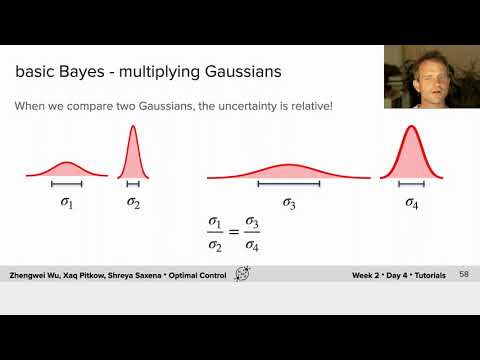

In [ ]:
# @title Video 2: Multiplying Gaussians
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='areR25_0FyY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

When we multiply Gaussians, we are not multiplying random variables but the actual underlying distributions. If we multiply two Gaussian distributions, with means $\mu_1$ and $\mu_2$ and standard deviations $\sigma_1$ and $\sigma_2$, we get another Gaussian. The Gaussian resulting from the multiplication will have mean $\mu_3$ and standard deviation $\sigma_3$ where:

$$
\mu_{3} = a\mu_{1} + (1-a)\mu_{2}
$$
$$
\sigma_{3}^{-2} = \sigma_{1}^{-2} + \sigma_{2}^{-2}\\
a = \frac{\sigma_{1}^{-2}}{\sigma_{1}^{-2} + \sigma_{2}^{-2}}
$$

This may look confusing but keep in mind that the information in a Gaussian is the inverse of its variance: $\frac{1}{\sigma^2}$. Basically, when multiplying Gaussians, the mean of the resulting Gaussian is a weighted average of the original means, where the weights are proportional to the amount of information of that Gaussian. The information in the resulting Gaussian is equal to the sum of informations of the original two. We'll dive into this in the next demo.

### Interactive Demo 2.2: Multiplying Gaussians 

We have implemented the multiplication of two Gaussians for you. Using the following widget, we are going to think about the information and combination of two Gaussians. It In our case, imagine we want to find the middle location between the satellite and the space mouse. This would be the center (average) of the two locations. Because we have uncertainty, we need to weight our uncertainty in thinking about the most likely place. 

In this demo, $\mu_{1}$ and $\sigma_{1}$ are the mean and standard deviation of the distribution over satellite location, $\mu_{2}$ and $\sigma_{2}$ are the mean and standard deviation of the distribution over space mouse location, and $\mu_{3}$ and $\sigma_{3}$ are the mean and standard deviation of the distribution over the center location (gained by multiplying the first two).

Questions:

1. What is your uncertainty (how much information) do you have about $\mu_{3}$ with $\mu_{1} = -2, \mu_{2} = 2, \sigma_{1} = \sigma_{2} = 0.5$?
2. What happens to your estimate of $\mu_{3}$ as $\sigma_{2} \to \infty$? (In this case, $\sigma$ only goes to 11... but that should be loud enough.)
3. What is the difference in your estimate of $\mu_{3}$ if $\sigma_{1} = \sigma_{2} = 11$? What has changed from the first example?
4. Set $\mu_{1} = -4, \mu_{2} = 4$ and change the $\sigma$s so that $\mu_{3}$ is close to $2$. How many $\sigma$s will produce the same $\mu_{3}$?
5. Continuing, if you set $\mu_{1} = 0$, what $\sigma$ do you need to change so $\mu_{3} ~= 2$?
6. If $\sigma_{1} = \sigma_{2} = 0.1$, how much information do you have about the average?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_information,
                  mu1 = FloatSlider(min=-5.0, max=-0.51, step=0.01, value=-2.0, description="µ_1",continuous_update=False),
                  mu2 = FloatSlider(min=0.5, max=5.01, step=0.01, value=2.0, description="µ_2",continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=11.01, step=0.01, value=1.0, description="σ_1", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=11.01, step=0.01, value=1.0, description="σ_2", continuous_update=False)
                  )

In [ ]:
# to_remove explanation

#. 1) Information is ~ 1/variance, so the new information you have is roughly 1/(0.5^2 + 0.5^2)
#.    (compared to 1/0.5^2) for each original measurement.

#. 2) The estimate will be almost entirely dependent on the mu_{1}! There is almost no
#.    information from mu_{2}.

#. 3) Because the variances are the same, the amount of information you have about the center
#.    is lower (very low in fact), but the mean doesn't change!

#. 4) There are an infinite number of variances that will produce the same (relative) weighting.
#.    The only thing that matters is the relative means and relative variances!

#. 5) This is the same intuition, it's the relative weightings that matter, so you can only
#.    think about the result (in this case the variance of the second Gaussian) relative to
#.    the first.

#. 6) As the variances -> zero, the amount of information goes to infinity!

To start thinking about how we might use these concepts directly in systems neuroscience, imagine you want to know how much information is gained combining (averaging) the response of two neurons that represent locations in sensory space (think: how much information is shared by their receptive fields). You would be multiplying Gaussians!

## Section 2.3: Mixtures of Gaussians


Video available at https://youtube.com/watch?v=5zoRO10urSk


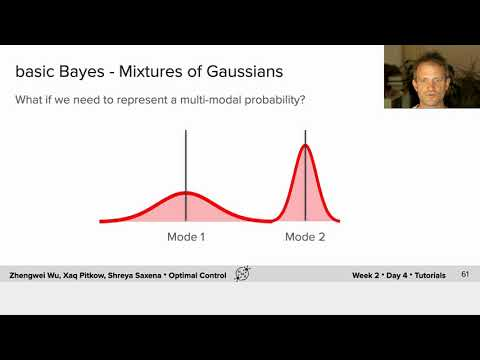

In [ ]:
# @title Video 3: Mixtures of Gaussians
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='5zoRO10urSk', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


What if our continuous distribution isn't well described by a single bump? For example, what if the Astrocat is often either in one place or another - a Gaussian distribution would not capture this well! We need a multimodal distribution. Luckily, we can extend Gaussians into a *mixture of Gaussians*, which are more complex distributions.  

In a Gaussian mixture distribution, you are essentially adding two or more weighted standard Gaussian distributions (and then normalizing so everything integrates to 1). Each standard Gaussian involved is described, as normal, by its mean and standard deviation. Additional parameters in a mixture of Gaussians are the weights you put on each Gaussian (π). The following demo should help clarify how a mixture of Gaussians relates to the standard Gaussian components. We will not cover the derivation here but you can work it out as a bonus exercise.

Mixture distributions are a common tool in Bayesian modeling and an important tool in general.



### Interactive Demo 2.3: Exploring Gaussian mixtures

We will examing a mixture of two Gaussians. We will have one weighting parameter, π, that tells us how to weight one of the Gaussians. The other is weighted by 1 - π. 

Use the following widget to experiment with the parameters of each Gaussian and the mixing weight ($\pi$) to undersand how the mixture of Gaussian distribution behaves.

Discuss the following questions:

1. What does increasing the weight $\pi$ do to the mixture distribution (dark blue)? 
2. How can you make the two bumps of the mixture distribution further apart?
3. Can you make the mixture distribution have just one bump (like a Gaussian)?
4. Any other shapes you can make the mixture distribution resemble other than one nicely rounded bump or two separate bumps?


In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(gaussian_mixture,
            mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_1", continuous_update=False),
            mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_2", continuous_update=False),
            sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_1", continuous_update=False),
            sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_2", continuous_update=False),
            factor = FloatSlider(min=0.1, max=0.9, step=0.01, value=0.5, description="π", continuous_update=False))

In [ ]:
# to_remove explanation

#.  1) Increasing the weight parameter makes the mixture distribution more closely 
#.   resemble p(x). This makes sense because it is weighting p(x) in the sum of Gaussians.


#.  2) You can move the two bumps of the mixture model further apart by making the means
#.    u_1 and u_2 of the two Gaussians more different (having one at -4 and one at 4 for
#.    example)


#.  3) If you make the means of the two Gaussians very similar, the mixture will resemble 
#.     a single Gaussian (u_1 = 0.25, u_2 = 0.3 for example)

#.  4) You can make a bunch of shapes if the two Gaussian components overlap at all.
#.     If they're completely separated, you'll just get two Gaussian looking bumps
#.     

---
# Section 3: Utility 



Video available at https://youtube.com/watch?v=I5H7Anh3FXs


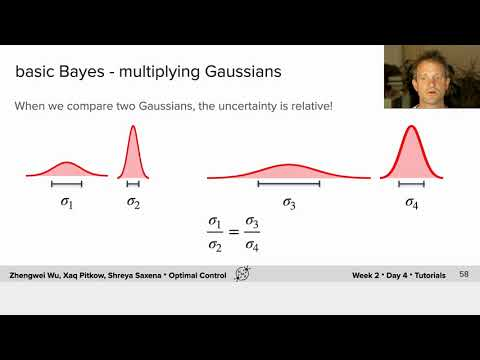

In [ ]:
# @title Video 4: Utility
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='I5H7Anh3FXs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

We want to know where Astrocat is. If we were asked to provide the coordinates, for example to display them for Ground Control or to note them in a log, we are not going to provide the whole probability distribution! We will give a single set of coordinates, but we first need to estimate those coordinates. Just like in the last tutorial, this may not be as easy as just what is most likely: we want to know how good or bad it is if we guess a certain location and the Astrocat is in another. 


As we have seen, utility represents the gain (or if negative, loss) for us if we take a certain action for a certain value of the hidden state. In our continuous example, we need a function to be able to define the utility with respect to all possible continuous values of the state. Our action here is our guess of the Astrocat location.

We are going to explore this for the Gaussian distribution, where our estimate is $\hat{\mu}$ and the true hidden state we are interested in is $\mu$. 

A loss function determines the "cost" (or penalty) of estimating $\hat \mu$ when the true or correct quantity is really $\mu$ (this is essentially the cost of the error between the true hidden state we are interested in: $\mu$ and our estimate: $\hat \mu$). A loss function is equivalent to a negative utility function.


## Section 3.1: Standard loss functions

There are lots of different possible loss functions. We will focus on three: **mean-squared error** where the loss is the different between truth and estimate squared, **absolute error** where the loss is the absolute difference between truth and estimate, and **Zero-one Loss** where the loss is 1 unless we're exactly right (the estimate equals the truth). We can represent these with the following formulas:

$$
\begin{eqnarray}
\textrm{Mean Squared Error} &=& (\mu - \hat{\mu})^2 \\ 
\textrm{Absolute Error} &=& \big|\mu - \hat{\mu}\big| \\ 
\textrm{Zero-One Loss} &=& \begin{cases}
                            0,& \textrm{if } \mu = \hat{\mu} \\
                            1,              & \textrm{otherwise}
                            \end{cases}
\end{eqnarray}
$$

We will now explore how these different loss functions change our expected utility!

Check out the next cell to see the implementation of each loss in the function `calc_loss_func`.


In [ ]:
# @markdown Execute this cell to enable the function `calc_loss_func`

def calc_loss_func(loss_f, mu_true, x):
    error = x - mu_true
    if loss_f == "Mean Squared Error":
        loss = (error)**2
    elif loss_f == "Absolute Error":
        loss = np.abs(error)
    elif loss_f == "Zero-One Loss":
        loss = (np.abs(error) >= 0.03).astype(np.float)
    return loss


### Interactive demo 3: Exploring Loss with different distributions

Let's see how our loss functions interact with probability distributions to affect expected utility and consequently, the action we take.

Play with the widget below and discuss the following:

1. With a Gaussian distribution, does the peak of the expected utility ever change position on the x-axis for the three different losses? This peak denotes the action we would choose (the location we would guess) so in other words, would the different choices of loss function affect our action?
2. With a mixture of Gaussian distribution with two bumps, does the peak of the expected loss ever change position on the x-axis for the three different losses?
3.  Find parameters for a mixture of Gaussians that results in the mean, mode, and median all being distinct (not equal to one another). With this distribution, how does the peak of the expected utility correspond to the mean/median/mode of the probability distribution for each of the three losses?
4. When the mixture of Gaussians has two peaks that are exactly the same height, how many modes are there?




In [ ]:
# @markdown Execute this cell to enable the widget

widget = interact(loss_plot_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians"], 
                      value="Gaussian", description="Distribution: "))

In [ ]:
# to_remove explanation

#.  1) No, no matter what parameters we choose for the Gaussian, the peak of the expected
#.    utility is the same. In other words, we would choose the same action (provide the same
#.    location estimate) for all 3 estimates.

#.  2) Yes, the peak of expected utility is in different locations for each loss when using
#.     a mixture of Gaussians distribution. 

#.  3) When using mean-squared error, the peak is at the location of the mean. For 
#.     absolute error, the peak is located at the median. And for zero-one loss, the 
#.     peaks are at the two mode values.

#.  4) When a distribution has more than one maximum, it is multi-modal! This means
#.     it can have more than one mode. You will only ever have one mean and one median.


You can see that what coordinates you would provide for Astrocat aren't necessarily easy to guess just from the probability distribution. You need the concept of utility/loss and a specific loss function to determine what estimate you should give.

For symetric distributions, you will find that the mean, median and mode are the same. However, for distributions with *skew*, like the Gamma distribution or the Exponential distribution, these will be different. You will be able to explore more distributions as priors below.

## Section 3.2: A more complex loss function

The loss functions we just explored were fairly simple and are often used. However, life can be complicated and in this case, Astrocat cares about both being near the space mouse and avoiding the satellite. This means we need a more complex loss function that captures this! 

We know that we want to estimate Astrocat to be closer to the mouse, which is safe and desirable, but further away from the satellite, which is dangerous! So, rather than thinking about the *Loss* function, we will consider a generalized utility function that considers gains and losses that *matter* to Astrocat!

In this case, we can assume that depending on our uncertainty about Astrocat's probable location, we may want to 'guess' that Astrocat is close to 'good' parts of space and further from 'bad' parts of space. We will model these utilities as Gaussian gain and loss regions--and we can assume the width of the Gaussian comes from our uncertainty over where the Space Mouse and satellite are.

Let's explore how this works in the next interactive demo.


### Interactive demo 3.2: Complicated cat costs

Now that we have explored *Loss* functions that can be used to determine both formal *estimators* and our expected loss given our error, we are going to see what happens to our estimates if we use a generalized utility function.

Questions:

1. As you change the $\mu$ of Astrocat, what happens to the expected utility?
2. Can the EU be exactly zero everywhere?
3. Can the EU be zero in a region around Astrocat but positive and negative elsewhere?
4. As our uncertainty about Astrocat's position increases, what happens to the expected utility?

In [ ]:
# @markdown Execute this cell to enable the widget

widget = interact(plot_simple_utility_gaussian,
                  mu = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ", continuous_update=False),
                  sigma = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False))

In [ ]:
# to_remove explanation

#. 1) As Astrocat's mean get closer to the mean of the gain (or loss), the EU become dominated
#.    by only the gain or loss.

#. 2) Only if the mean and variances of both the gain and loss regions are exactly the same.
# .   (Set one of the variances 0.01 more than the other to see this.)

#. 3) If the variances of the gain and loss function are small enough relative to the position
#.    of Astrocat, there will be a 'neutral' region. As the variances increase, this will go away.

#. 4) As the uncertainty of Astrocat's location increases (relative to the gain and loss variances).
#.    there will be a continuous increase in utility from the peak of the loss region to the peak of the
#.    gain region. Also, this will depend on the mean of Astrocat's distribution! The larger the variance
#.    the more sensitive the expected utility is to both the gains and losses!

---
# Section 4: Correlation and marginalization

In this section we will explore a two dimensional Gaussian, often defined as a two-dimension vector of Gaussian random variables. This is, in essence, the joint distribution of two Gaussian random variables.



## Video 5: Correlation and marginalization

Video available at https://youtube.com/watch?v=NSDd0kvQtcY


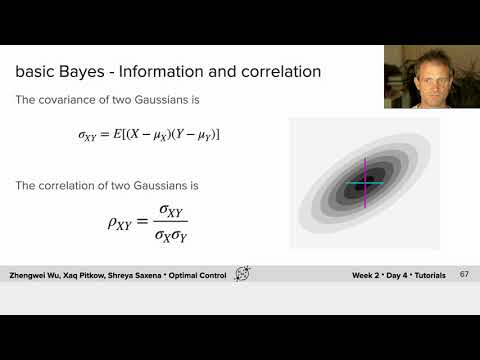

In [ ]:
# @title Video 5: Correlation and marginalization
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='NSDd0kvQtcY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 4.1: Correlation

If the two variables in a two dimensional Gaussian are independent, looking at one tells us nothing about the other. But what if the the two variables are correlated (covary)?

The covariance of two Gaussians with means $\mu_X$ and $\mu_Y$ and standard deviations $\sigma_X$ and $\sigma_Y$is:

$$
\sigma_{XY} = E[(X-\mu_{X})(Y-\mu_{Y})]
$$

$E$ here denotes the expected value. So the covariance is the expected value of the random variable X minus the mean of the Gaussian distribution on X times the random variable Y minus the mean of the Gaussian distribution on Y.

The correlation is the covariance normalized, so that it goes between -1 (exactly anticorrelated) to 1 (exactly correlated).

$$
\rho_{XY} = \frac{\sigma_{XY}}{\sigma_{X}\sigma_{Y}}
$$

These are key concepts and while we are considering two hidden states (or two random variables), they extend to $N$ dimensional vectors of Gaussian random variables. You will find these used all over computational neuroscience.



### Interactive demo 4.1: Covarying 2D Gaussian

Let's explore this 2D Gaussian (i.e. joint distribution of two Gaussians).

Use the following widget to think about the following questions:

1. If these variables represent hidden states we care about, what does observing one tell us about the other? How does this depend on the correlation?
2. How does the shape of the distribution change when we change the means? The variances? The correlation?
3. If we want to isolate one or the other hidden state distributions, what do we need to do? (Hint: think about Tutorial 1.)

In [ ]:
# @markdown Execute the cell to enable the widget
widget = interact(plot_mvn2d,
                  mu1 = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="µ_1", continuous_update=False),
                  mu2 = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="µ_2", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=1.5, step=0.01, value=0.5, description="σ_1", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=1.5, step=0.01, value=0.5, description="σ_2", continuous_update=False),
                  corr = FloatSlider(min=-0.99, max=0.99, step=0.01, value=0.0, description="ρ", continuous_update=False))


In [ ]:
# to_remove explanation

#. 1) The higher the correlation, the more shared information there is. So, the probabilities of the  
#.    second hidden state are more dependent on the first (and vice versa).

#. 2) The means control only the location! The variances determine the spread in X and Y. The
#.    correlation is the only factor that controls the degree of the 'rotation', where we can think
#.    about the correlation as forcing the distribution to be more along one of the diagonals or ther
#.    other.

#. 3) We would need to marginalize! We will do this next.

## Section 4.2: Marginalization and information

We learned in Tutorial 1 that if we want to measure the probability of one or another variable, we need to average over the other. When we extend this to the correlated Gaussians we just played with, marginalization works the same way. Let's say that the two variables reflect Astrocat's position in space (in two dimensions). If we want to get our uncertainty about Astrocat's X or Y position, we need to marginalize. 

However, let's imagine we have a measurement from one of the variables, for example X, and we want to understand the uncertainty we have in Y. We no longer want to marginalize because we know X, we don't need to ignore it! Instead, we can calculate the conditional probability $P(Y|X=x)$. You will explore the relationship between these two concepts in the following interactive demo.

But first, let's remember that we can also think about the amount of uncertainty as inversely proportional to the amount of information we have about each variable. This is important, because the joint information is determined by the correlation. For our Bayesian approach, the important intuition is that we can also think about the mutual information between the prior and the likelihood following a measurement.






### Interactive demo 4.2: Marginalizing 2D Gaussians

Use the following widget to think consider the following questions:

1. When is the marginal distribution the same as the conditional probability distribution? Why?
2. If $\rho$ is large, how much information can we gain (in addition) looking at both variables vs just considering one?
3. If $\rho$ is close to zero, but the variances of the two variables are very different, what happens to the conditional probability compared to the marginals? As $\rho$ changes?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_marginal,
                  sigma1 = FloatSlider(min=0.1, max=1.1, step=0.01, value=0.5, description="σ_x", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=1.1, step=0.01, value=0.5, description="σ_y", continuous_update=False),
                  c_x = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="Cx", continuous_update=False),
                  c_y = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="Cy", continuous_update=False),
                  corr = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description="ρ", continuous_update=False))


In [ ]:
# to_remove explanation

#. 1) The conditional probability distribution is using a measurement to restrict the likely value of
#.    one of the variables. If there is correlation, this will also affect what we know (conditionally)
#.    about the other! However, the marginal probability *only* depends on the direction along
#.    which we are marginalizing. So, when the conditional probability is based on a measurement at the
#.    means, it is the same as marginalization, as there is no additional information. A further note
#.    is that we can also marginalize along other directions (e.g. a diagonal), but we are not exploring
#.    this here.

#. 2) The larger the correlation, the more shared information. So the more we gain about the
#.    second variable (or hidden state) by measuring a value from the other.

#. 3) The variable (hidden state) with the lower variance will produce a narrower
#.    conditional probabilty for the other variable! As you shift the correlation, you will see
#.    small changes in the variable with the low variance shifting the conditional mean of the 
#.    variable with the large variance! (So, if X has low variance, changing CY has a big effect.)

---
# Section 5: Bayes' theorem for continuous distributions



## Section 5.1: The Gaussian example

Bayes' rule tells us how to combine two sources of information: the prior (e.g., a noisy representation of Ground Control's expectations about where Astrocat is) and the likelihood (e.g., a noisy representation of the Astrocat after taking a measurement), to obtain a posterior distribution (our belief distribution) taking into account both pieces of information. Remember Bayes' rule:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

We will look at what happens when both the prior and likelihood are Gaussians. In these equations, $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu$ and $\sigma^2$:
$$
\mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \; \exp \bigg( \frac{-(x-\mu)^2}{2\sigma^2} \bigg)
$$


When both the prior and likelihood are Gaussians, Bayes Rule translates into the following form:

$$
\begin{array}{rcl}
\text{Likelihood} &=& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \\
\text{Prior} &=& \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
\text{Posterior} &=& \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) \\
&\propto& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2)
\end{array}
$$

We get the parameters of the posterior from multiplying the Gaussians, just as we did in Secton 2.2.



### Interactive Demo 5.1: Gaussian Bayes
Let's consider the following questions using the following interactive demo:

1. For a Gaussian posterior, explain how the information seems to be combining. (Hint: think about the prior exercises!)
2. What is the difference between the posterior here and the Gaussian that represented the average of two Gaussians in the exercise above?
3. How should we think about the relative weighting of information between the prior and posterior?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_bayes,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False))

In [ ]:
# to_remove explanation

#. 1)  We see that the posterior is a weighted average of the prior and likelihood,
#.     where the weights correspond to the information in each (or inverse variance).
#.     That is, if the prior has lower variance, the mean of the posterior is pulled
#.     towards it. If the likelihood has lower variance, the mean of the posterior is
#.     pulled towards it

#. 2)  When we simply multiplied the Gaussians, we end up with an a true Probability 
#.     Density Function (PDF)--that is, the integral under the curve is one. However,
#.     when we calculate the likelihood * prior, it will look like a Gaussian, but it 
#.     must be normalized by the marginal likelihood so that the posterior is a true
#.     PDF.

#. 3) The prior and posterior can both be thought of as having information, as we
#.    described earlier. So this means you can think of the weighting applied to each
#.    as proportional to the amount of information each contain. For Gaussians, you
#.    know how to calculate this directly.


## Section 5.2: Exploring priors

What would happen if we had a different prior distribution for Astrocat's location? Bayes' Rule works exactly the same way if our prior is not a Guassian (though the analytical solution may be far more complex or impossible). Let's look at how the posterior behaves if we have a different prior over Astrocat's location.

Consider the following questions:

1. Why does the posterior not look Gaussian when you use a non-Gaussian prior?
2. What does having a flat prior mean?
3. How does the Gamma prior behave differently than the others?
4. From what you know, can you imagine the likelihood being something other than a Gaussian?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_prior_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians", "Uniform", "Gamma"], 
                      value="Gaussian", description="Prior: "))

In [ ]:
# to_remove explanation

#. 1) If we do not use a Gaussian prior, we will not necessarily have a Gaussian 
#.    posterior as the type of posterior distribution depends on the types of both the
#.    prior and likelihood distributions.

#. 2) A flat prior means you have no helpful prior information coming in: all options are
#.    equally likely. 

#. 3) The Gamma prior has skew, which is the property of not being symmetric, so, like the
#.    mixture of Gaussians, it has different mean, median and mode. But unlike all the other
#.    distributions, the Gamma PDF is positive only for x > 0, so it has a hard truncation,
#.    even when its parameters cause the values just above x = 0 to be large. In fact, the
#.    the Exponential distribution, Erlang distribution, and chi-square distribution are
#.    special cases of the gamma distribution. In our example, you can see that the posterior
#.    also incoreporates the hard truncation.

#. 4) We have only changed the prior, but the prior and the likelihood are just probability
#.    distributions. In principle, they can be any properly defined probability distribution.
#.    An example that may seem bizare is the Driac (delta) function, which is a PDF, that has
#.    all it's probability density in one location, desite being continuous. But in the case
#.    of the brain, it's possible that strange likelihood distributions could be used. However,
#.    for the same reasons we, as scientists, like exponential family distributions, it may be
#.    that evolution selected only ways of representing probability distributions that had useful
#.    properties.

---
# Section 6: Bayesian decisions



## Section 6.1: Bayesian estimation on the posterior

Now that we understand that the posterior can be something other than a Gaussian, let's revisit **Loss** functions. In this case, we can see that the posterior can take many forms. 

 

### Interactive Demo 6.1: Standard loss functions with various priors

Questions:

1. If we have a bi-modal prior, how do the different loss functions potentially inform us differently about what we learn?
2. Why do the different loss functions behavior differently with respect to the shape of the posterior? When do they produce different expected loss?
3. For the mixture of Gaussians, describe the situations where the expected loss will look different from the Gaussian case.


In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_bayes_loss_utility_switcher,
                  what_to_plot = widgets.Dropdown(
                      options=["Gaussian", "Mixture of Gaussians", "Uniform", "Gamma"], 
                      value="Gaussian", description="Prior: "))

In [ ]:
# to_remove explanation

# 1. The minimium of the different loss functions correspond to the mean, median, 
#.   and mode of the posterior (just as in Interactive Demo 3). If we have a bi-modal 
#.   prior, those properties of the posterior can be distinct.

#. 2. The posterior is just another probability distribution, so all the properies we
#.    saw in Interactive Demo 3, are true of the posterior two—-even though in this case,
#.    the posterior inherited the non-symetric properties from the prior. So, in this
#.    example, any prior that itself has a different mean, median and mode with also 
#.    produce differents across their equivilant Loss functions.

#. 3. As long as the posterior probability densities are symetric around the true mean
#.    (hidden state), the MSE and ABS loss functions will look the same as for a Gaussian
#.    prior. The mean and the median are the same for symetric distributions. (When the 
#.    mean exists--look up the Cauchy distributions.) The mode will be the same as the
#.    mean and median, when the distribution is unimodal (and therefor when the mixture
#.    means are the same. There can also be two modes with the mixture prior!

## Section 6.2: Bayesian decisions

Finally, we can combine everything we have learned so far! 

Now, let's imagine we have just received a new measurement of Astrocat's location. We need to think about how we want to decide where Astrocat is, so that we can decide how far to tell Astrocat to move. However, we want to account for the satellite and Space Mouse location in this estimation. If we make an error towards the satellite, it's worse than towards Space Mouse. So, we will use our more complex utility function from Section 3.2. 


### Interactive Demo 6.2: Complicated cat costs with various priors


Questions:

1. If you have a weak prior and likelihood, how much are you relying on the utility function to guide your estimation?
2. If you get a good measurement, that is a likelihood with low variance, how much does this help?
3. Which of the factors are most important in making your decision?

In [ ]:
# @markdown Execute this cell to enable the widget
widget = interact(plot_utility_gaussian,
                  mu1 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-0.5, description="µ_prior", continuous_update=False),
                  mu2 = FloatSlider(min=-4.0, max=4.0, step=0.01, value=0.5, description="µ_likelihood", continuous_update=False),
                  sigma1 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_prior", continuous_update=False),
                  sigma2 = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_likelihood", continuous_update=False),
                  mu_g = FloatSlider(min=-4.0, max=4.0, step=0.01, value=1.0, description="µ_gain", continuous_update=False),
                  mu_c = FloatSlider(min=-4.0, max=4.0, step=0.01, value=-1.0, description="µ_cost", continuous_update=False),
                  sigma_g = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_gain", continuous_update=False),
                  sigma_c = FloatSlider(min=0.1, max=2.0, step=0.01, value=0.5, description="σ_cost", continuous_update=False),
                  plot_utility_row=fixed(True))

In [ ]:
# to_remove explanation

# 1)  When you have a weak prior and likelihood (high variance for both so not 
#.     informative), the utility function heavily dictates the shape of the expected utility 
#.     and final decision (the location of the max of the expected utility)

# 2) How much it helps guide your decision depends on the prior and utility function.
#.   If the likelihood is much more informative that the prior (lower variance), it
#.   will help clarify your decision of location quite a bit.

# 3) None are always the "most important". It depends on the interplay of all components, 
#.   especially the information of the prior and likelihood. If you have an informative 
#.  prior, that will heavily influence the posterior and thus the expected utility. 
#.   If you have an informative likelihood, that will drive the posterior. And if neither
#.   is informative, the utility function becomes very important,

---
# Summary

In this tutorial, you extended your exploration of Bayes Rule and the Bayesian approach in the context of finding and choosling a location for Astrocat.

Specifically, we covered:

* The Gaussian distribution and its properties

* That the likelihood is the probability of the measurement given some hidden state

* Information shared between Gaussians (via multiplication of PDFs and via two-dimensional distributions)

* That how the prior and likelihood interact to create the posterior, the probability of the hidden state given a measurement, depends on how they covary

* That utility is the gain from each action and state pair, and the expected utility for an action is the sum of the utility for all state pairs, weighted by the probability of that state happening. You can then choose the action with highest expected utility.
 